<a href="https://colab.research.google.com/github/FRJackson/hw/blob/main/42-finalProblem1_HW6_IMDB_LSTM(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GR5242 HW06 Problem 1: IMDB review classification**

**For coding questions, look for filling in ########## Your code here ##########; for reflection questions, write down your answers in the "Your Answer:" text block.**


There are many examples of external links to documentation. If you see reference to a `pytorch` or similar object, try hovering over the word to see if documentation is linked.

## Description:

In homework 5 you have worked on comparing a crude BoW+Logistic classification to a Word2vec+CNN classification on the sentiment analysis of IMDB reviews. In this homework you will explore more recent and state-of-the-art methods used for text classification. The focus of this problem is to implement from scratch this architecture: [Bi-directional LSTM with attention mechanism and convolutional layer for text classification](https://www-sciencedirect-com.ezproxy.cul.columbia.edu/science/article/pii/S0925231219301067?casa_token=fLLUOZOdAacAAAAA:leMyhdLJLYixk7KIRKflN38kAhyTGs61uHPjh9dE5x6-JanSdLQ95DEH11TilKDVTG7gDHiodKA).

The problem is outlined as such:

0. Setting up the data: this part reuses code you have completed in HW5.
1. Implementing the bidirectional LSTM
2. Implementing an attention mechanism
3. Conclusion

4. *Optional: use BERT+Bi-LSTM*


This problem will alternate between coding questions as well as reading/reflection questions referring to the paper. Please note that you do not have to do the optional question, if you do, it will be counted as bonus along with other bonus questions you have completed.



# 0. Preparation

Basic overview of the idea behind the AC-BiLSTM architecture: it combines a word embedding to convolutional layer to extract features, then those features are fed into the Bi-LSTM layer and attention layers to enrich the context representation.
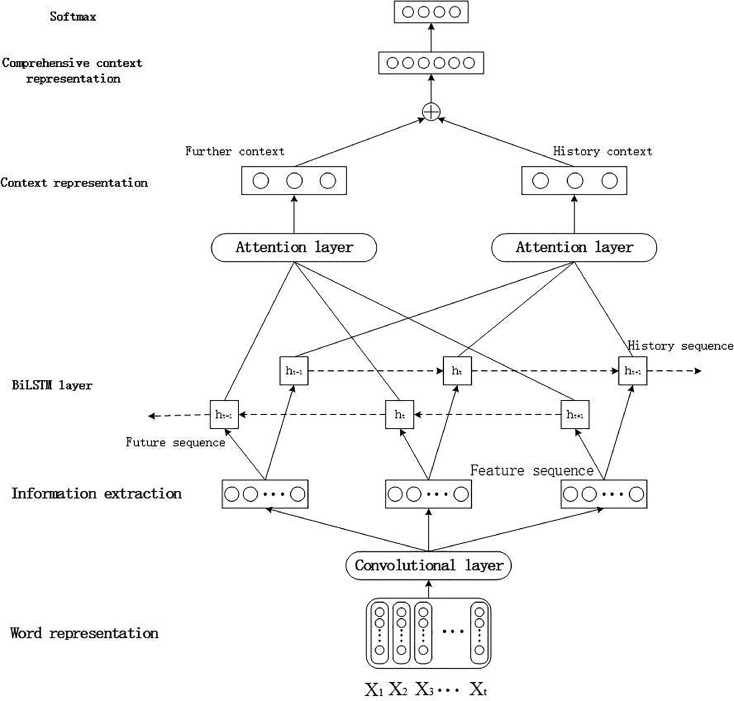

## a) Data loading and processing

**Import modules for later usage**

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU is available.


It is recommended you use GPU acceleration for this problem. You can run this notebook on Google Colab GPU for free by connecting to T4 under "Connect to a hosted runtime".  **Please note that using T4 GPU, training for each model for the 10 epochs should not exceed 20min.** If it does, you might want to double check your code.

We first load the IMDB movie review [data](https://ai.stanford.edu/~amaas/data/sentiment/) which contains 25,000 movie reviews for training and 25,000 for testing. These movie reviews are labelled for sentiment analysis. You can also find some processed (tokenized, cleaned and vectorized) version of this data in `keras.datasets` to use directly in the pipeline for embedding+classification.

The data is split into two folders `train` and `test` with each having subfolders grouping them into `neg` and `pos` labels. The `train` folder has an additional `unsup` folder containing unlabelled data for unsupervised learning.

In [3]:
import os, tarfile, urllib.request

# if the folder has not yet been downloaded and extracted
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATA_DIR = "aclImdb" # Replace with your download folder

if not os.path.exists(DATA_DIR):
    print("Downloading IMDB dataset...")
    urllib.request.urlretrieve(url, "aclImdb_v1.tar.gz")

    print("Extracting...")
    with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
        tar.extractall()
    print("Done!")
else:
    print("IMDB dataset already exists.")


Extracting...


/tmp/ipython-input-641042835.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Done!


In [4]:
from pathlib import Path
# The following function helps you load the training and test data where each
# review is a single string vector with label 1 if positive, 0 otherwise
# We should be loading 25000 train and 25000 test reviews.

def load_imdb_split(split_dir):
    texts, labels = [], []
    for label_type in ["pos", "neg"]:
        dir_path = Path(split_dir)/label_type
        for file_path in dir_path.iterdir():
            with open(file_path, encoding="utf-8") as f:
                texts.append(f.read())
            labels.append(1 if label_type == "pos" else 0)
    return texts, labels

train_texts, train_labels = load_imdb_split(DATA_DIR + "/train")
test_texts, test_labels   = load_imdb_split(DATA_DIR + "/test")

print(f"Loaded {len(train_texts)} train and {len(test_texts)} test reviews.")

Loaded 25000 train and 25000 test reviews.


In [5]:
# Display the first train review's first 500 characters
pprint(train_texts[0][:500])

('Omigosh, this is seriously the scariest movie i have ever, ever seen. To say '
 'that i love horror movies would be an understatement, and i have seen heaps '
 "(considering the limited availability in New Zealand, that's quite a lot), "
 'but never before have i had to sleep with the light on...until i saw The '
 'Grudge.<br /><br />Some may say that it is a rip off of The Ring (both based '
 'on Japanese horror movies), both similar (yet different) story lines, but '
 'the Grudge holds its own as a terrifying movie -')


## b) Using a pretrained `Word2Vec` embedding

A cornerstone of word-embedding development is the `word2vec` architecture proposed in Mikolov's seminal paper [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781). The approach adopted is one of *distributional semantics* meaning that a word's meaning should be coherent to the other words it frequently appears with: the notion of **context** has to be rigorously defined. A natural heuristic is that a shorter context window will encode more syntactic properties (for example the structure *determiner + noun + verb* --> *the cat purrs*) while a larger context window will encode more semantic properties within a document (for example multiple related nouns will appear).


We load a pretrained `word2vec` embedding. We will have to install the `gensim` package and download a pretrained model on a corpus of Google News articles. Let's investigate how this looks like.

In [6]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 83.9 MB/s eta 0:00:00


This might take a minute to load.

In [7]:
def load_embedding_model():
    """ Load word2vec Vectors
        Return:
            wv_from_bin: All embeddings
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Loaded vocab size 3000000


In [8]:
import re, html, unicodedata
from sklearn.feature_extraction.text import CountVectorizer
# Here we give an example of steps one can take when cleaning text data before construction BoW
# basic_clean will be a custom function we can establish for specific cleaning steps. Here IMDB
# reviews are scrapped from the web page, the url and tag replacement steps can be crucial here
# depending on the downstream method

URL_RE   = re.compile(r'https?://\S+|www\.\S+')
TAG_RE   = re.compile(r'<[^>]+>')
NUM_RE   = re.compile(r'\b\d+([.,]\d+)*\b')
WS_RE    = re.compile(r'\s+')
APOSTROPHE_RE = re.compile(r"[’`´]")
CONTRACTIONS = {
    "can't": "can not", "won't": "will not", "n't": " not",
    "'re": " are", "'s": " is", "'d": " would", "'ll": " will", "'ve": " have", "'m": " am"
}

def basic_clean(text):
    text = html.unescape(text) # HTML entities & tags removal
    text = TAG_RE.sub(' ', text)
    def strip_accents(s):
      return ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    text = strip_accents(text) #  normalize unicode & accents
    text = APOSTROPHE_RE.sub("'", text) # normalize apostrophes to plain '
    text = URL_RE.sub(' <url> ', text) # replace urls/emails/numbers with placeholders
    text = re.sub(r'\S+@\S+\.\S+', ' <email> ', text)
    text = NUM_RE.sub(' <num> ', text)
    for k, v in CONTRACTIONS.items(): #  expand contractions (eg negations)
        text = text.replace(k, v)
    text = re.sub(r"[^a-z0-9<> ]+", " ", text) #  remove punctuation (keep spaces and angle-bracket tokens)
    text = WS_RE.sub(' ', text).strip() # collapse whitespace
    return text

In [9]:
# We iterate all the corpus through our cleaning functions and tokenize it
# You can use some of the previously defined functions

def tokenize(s):
    s = s.lower()
    s = re.sub(r"[^a-z0-9']+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s.split()

def clean_tokenize(data_text):
    clean_train = [basic_clean(document) for document in data_text]
    tokens = [tokenize(clean_doc) for clean_doc in clean_train]
    return tokens

train_data = clean_tokenize(train_texts)
test_data = clean_tokenize(test_texts)

In [10]:
from collections import Counter

def build_vocab(token_docs, max_words=30000, skip_top=0, specials=("<pad>","<oov>")):
    PAD, OOV = specials
    freq = Counter([w for doc in token_docs for w in doc])
    most_common = [w for w,_ in freq.most_common(max_words + skip_top)][skip_top:]
    vocab = [PAD, OOV] + most_common
    word2idx = {w:i for i,w in enumerate(vocab)}
    return vocab, word2idx

vocab, word2idx = build_vocab(train_data)

def build_w2v_embedding_matrix(word2idx, wv, pad_idx=0, oov_idx=1, rand_scale=0.6):
    V = len(word2idx)
    D = wv.vector_size
    emb = np.random.normal(scale=rand_scale, size=(V, D)).astype("float32")
    emb[pad_idx] = 0.0

    found, known_rows = 0, []
    for w, i in word2idx.items():
        if w in wv:
            emb[i] = wv[w]
            found += 1
            if i not in (pad_idx, oov_idx):
                known_rows.append(i)

    if known_rows:
        emb[oov_idx] = emb[known_rows].mean(axis=0)

    print(f"Matched {found}/{V} ({found/V:.1%}) words to pretrained vectors.")
    return torch.tensor(emb)

In [11]:
all_lens = np.array([len(s) for s in train_data])
for p in (90, 95, 98, 99):
    print(f"P{p}: {np.percentile(all_lens, p):.0f}")

# e.g., pick 95th percentile as MAX_LEN:
MAX_LEN = int(np.percentile(all_lens, 95))
print("Chosen MAX_LEN:", MAX_LEN)

# Estimate truncation rate:
trunc_rate = (all_lens > MAX_LEN).mean()
print(f"Truncation rate at MAX_LEN={MAX_LEN}: {trunc_rate*100:.2f}%")

P90: 456
P95: 599
P98: 788
P99: 910
Chosen MAX_LEN: 599
Truncation rate at MAX_LEN=599: 4.99%


It seems reasonable to set the max sequence length to 600 so that all reviews have same length in the data loader. This foregoes the `collate` function we would have to define.

In [12]:
from torch.utils.data import Dataset, DataLoader


def encode(doc, word2idx, oov_idx=1):
    return [word2idx.get(w, oov_idx) for w in doc]

def pad_to_max_len(ids, max_len=600, pad_idx=0):
    ids = ids[:max_len]
    if len(ids) < max_len:
        ids += [pad_idx] * (max_len - len(ids))
    return ids


class TextDataset(Dataset):
  def __init__(self, data, labels, word2idx):
    assert len(data) == len(labels)
    self.X = []
    self.y = []
    for toks, y in zip(data, labels):
        ids = encode(toks, word2idx)
        ids = pad_to_max_len(ids)
        self.X.append(torch.tensor(ids, dtype=torch.long))
        self.y.append(torch.tensor([y], dtype=torch.float32))

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

train_dataloader = DataLoader(TextDataset(train_data, train_labels, word2idx),batch_size=64, shuffle=True)
test_dataloader = DataLoader(TextDataset(test_data, test_labels, word2idx), batch_size=64)


# 1. Bi-directional LSTM




Let's start with our Bi-directional LSTM component. You have seen in class that LSTMs are particular Recurrent Neural Network that are adapted for sequential modelling. In particular for an unidirectional RNN, the final state will reflect more information about the end of the text than the beginning. A bi-directional LSTM is trained forward and backward, which implies it accesses both "before" and "after" contexts which can lead to predictive benefits.

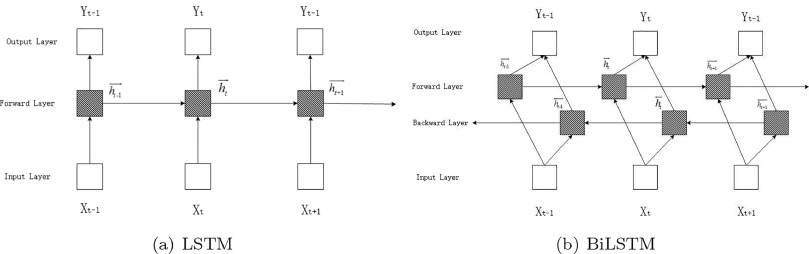

In practice, Pytorch has the LSTM layer ready to use via [`nn.LSTM`](https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html) class. To enable bi-directionality, we only need to pass `bidirectional=True` in the argument.


## Question 1.
Create the sentiment classifier class with Bi-LSTM by combining:
 - an **embedding** layer: taking the word embeddings defined previously, with frozen weights so they are not retrained during model training.
 - the **Bi-LSTM layer**: with 150 memory size
 - the **convolutional layer**: with 100 filters with window size of 3.
 - final **classifier head** comprised of a drop-out layer with rate 0.7 and linear layer on the concatenated bi-LSTM output.



In [13]:
embedding_matrix = build_w2v_embedding_matrix(
    word2idx,
    wv_from_bin,
    pad_idx=0,
    oov_idx=1
)
print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Vocab size: {embedding_matrix.shape[0]}")
print(f"Embedding dimension: {embedding_matrix.shape[1]}")

Matched 22524/30002 (75.1%) words to pretrained vectors.
Embedding matrix shape: torch.Size([30002, 300])
Vocab size: 30002
Embedding dimension: 300


This code outline is provided for structure but you can also use `nn.Sequential` or other ways to wrap the building block. It only matters that you have the right components doing the right things.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

#### YOUR CODE ####

class C_BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_filters,
                 kernel_size, pretrained_embeddings, freeze_embeddings=True,
                 dropout=0.7):
        super().__init__()

        # Embedding layer from Google News word2vec ()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings)
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False

        # Convolutional layer with 100 filters of window size 3
        self.conv = nn.Conv1d(in_channels=embed_dim,
                             out_channels=num_filters,
                             kernel_size=kernel_size,
                             padding=kernel_size//2)

        # Bi-directional LSTM with memory size dim of 150 per direction
        self.lstm = nn.LSTM(input_size=num_filters,
                           hidden_size=hidden_dim,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)

        # Classifier head
        self.dropout = nn.Dropout(dropout)
        # hidden_dim * 2 because bidirectional
        self.clf = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        # x: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)

        # Conv1d expects (batch, channels, length)
        conv_input = embedded.transpose(1, 2)  # (batch_size, embed_dim, seq_len)
        conv_out = F.relu(self.conv(conv_input))  # (batch_size, num_filters, seq_len)

        # Transpose back for LSTM
        lstm_input = conv_out.transpose(1, 2)  # (batch_size, seq_len, num_filters)

        # BiLSTM
        lstm_out, (h_n, c_n) = self.lstm(lstm_input)
        # lstm_out: (batch_size, seq_len, hidden_dim*2)

        # Use the last hidden state (concatenated forward and backward)
        # h_n: (num_layers*2, batch_size, hidden_dim)
        forward_hidden = h_n[-2, :, :]  # (batch_size, hidden_dim)
        backward_hidden = h_n[-1, :, :]  # (batch_size, hidden_dim)
        hidden = torch.cat([forward_hidden, backward_hidden], dim=1)

        # Classifier
        hidden = self.dropout(hidden)
        logits = self.clf(hidden)

        return logits


## Question 2.

Complete the code to run training. Instantiate the model, define the criterion.

In [15]:
V = len(vocab)
D = embedding_matrix.shape[1]
hidden_dim = 150
num_filters = 100
kernel_size = 3
dropout = 0.7

#### YOUR CODE HERE ####
model = C_BiLSTM(
    vocab_size=V,
    embed_dim=D,
    hidden_dim=hidden_dim,
    num_filters=num_filters,
    kernel_size=kernel_size,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=True,
    dropout=dropout,
).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # matches the paper

## Question 3.

Complete the training loop and evaluation. Train the model for 10 epochs and plot the learning curves and classification diagnostics. **Add** a few lines of a code so that you can save the best model in the sense of the model with lowest validation loss.

 Hint: You can use functions defined in HW 5.

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

#### YOUR CODE HERE ####

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predictions == batch_y).sum().item()
        total += batch_y.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_acc = correct / total

    return avg_loss, avg_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            total_loss += loss.item()

            predictions = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predictions == batch_y).sum().item()
            total += batch_y.size(0)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    avg_acc = correct / total

    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'])

    return avg_loss, avg_acc, cm, report

 10%|█         | 1/10 [00:16<02:30, 16.68s/it]

Epoch 1/10
Train Loss: 0.6754, Train Acc: 0.5842
Val Loss: 0.6462, Val Acc: 0.6142



 20%|██        | 2/10 [00:31<02:06, 15.76s/it]

Epoch 2/10
Train Loss: 0.6508, Train Acc: 0.6306
Val Loss: 0.6763, Val Acc: 0.5844



 30%|███       | 3/10 [00:46<01:48, 15.46s/it]

Epoch 3/10
Train Loss: 0.6252, Train Acc: 0.6552
Val Loss: 0.5102, Val Acc: 0.7715



 40%|████      | 4/10 [01:02<01:31, 15.32s/it]

Epoch 4/10
Train Loss: 0.5719, Train Acc: 0.7102
Val Loss: 0.4793, Val Acc: 0.7674



 50%|█████     | 5/10 [01:17<01:16, 15.23s/it]

Epoch 5/10
Train Loss: 0.4204, Train Acc: 0.8136
Val Loss: 0.3888, Val Acc: 0.8379



 60%|██████    | 6/10 [01:32<01:00, 15.18s/it]

Epoch 6/10
Train Loss: 0.3320, Train Acc: 0.8635
Val Loss: 0.3409, Val Acc: 0.8575



 70%|███████   | 7/10 [01:47<00:45, 15.21s/it]

Epoch 7/10
Train Loss: 0.2869, Train Acc: 0.8848
Val Loss: 0.3129, Val Acc: 0.8727



 80%|████████  | 8/10 [02:02<00:30, 15.17s/it]

Epoch 8/10
Train Loss: 0.2530, Train Acc: 0.9015
Val Loss: 0.3071, Val Acc: 0.8743



 90%|█████████ | 9/10 [02:17<00:15, 15.14s/it]

Epoch 9/10
Train Loss: 0.2274, Train Acc: 0.9134
Val Loss: 0.3169, Val Acc: 0.8670



100%|██████████| 10/10 [02:32<00:00, 15.27s/it]

Epoch 10/10
Train Loss: 0.2029, Train Acc: 0.9229
Val Loss: 0.3686, Val Acc: 0.8568




Best Model Performance (Lowest Validation Loss)
Test Loss: 0.3686
Test Accuracy: 0.8568


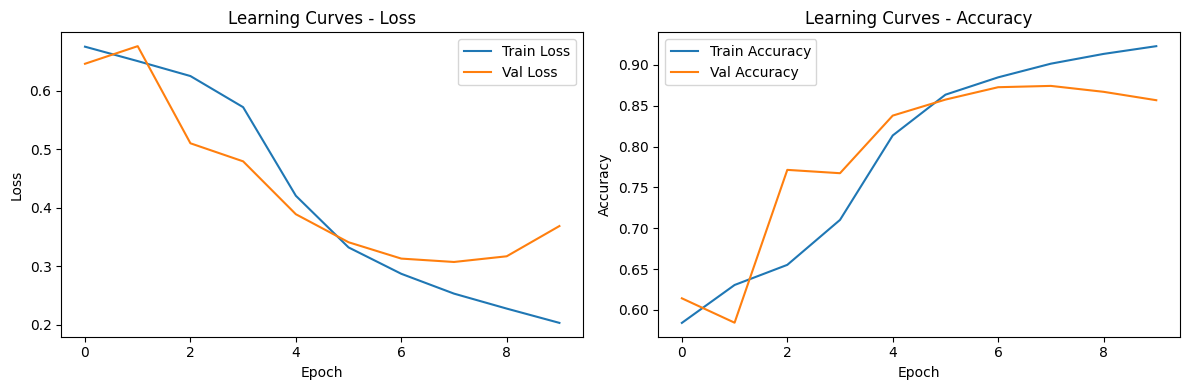

In [17]:
import matplotlib.pyplot as plt
from tqdm import tqdm

#### YOUR CODE HERE ###
# Training loop
EPOCHS = 10
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_loss = float('inf')
best_model_state = None

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, test_dataloader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")

# Load the best model (model with lowest validation loss)
model.load_state_dict(best_model_state)

# Final evaluation on test set
final_loss, final_acc, cm, report = evaluate(model, test_dataloader, criterion, device)

print(f"\n{'='*50}")
print(f"Best Model Performance (Lowest Validation Loss)")
print(f"{'='*50}")
print(f"Test Loss: {final_loss:.4f}")
print(f"Test Accuracy: {final_acc:.4f}")

# Plot curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Learning Curves - Loss')
ax1.legend()

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Learning Curves - Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()






In [18]:
#### YOUR CODE HERE ###
# Show diagnostics
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[11636   864]
 [ 2717  9783]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.93      0.87     12500
    Positive       0.92      0.78      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



# Implementing the attention mechanism


## Question 4.
The paper uses a simple attention mechanism to focus on the features of keywords.
1)  Can you explain in a few words what the attention mechanism does?
2)  Implement the attention mechanism by completing the code.





**Your answer:**

The core function of the attention mechanism is to assign different weights to different positions in the sequence, enabling the model to focus on the keywords or context that are more important to the task during prediction (such as "excellent" and "terrible" in sentiment analysis), and suppress irrelevant information (such as filler words and redundant modifications), thereby enhancing the effectiveness of context representation.

The attention mechanism in the paper is as such: given the outputs of the bi-LSTM $h_f$, $h_b$ (respectively from forward state and backward state), we obtain the context for each state $C_f$ and $C_b$ respectively via the simplest attention called **dot-product attention**.


* For $h \in \{h_f, h_b\}$ , $u_h = \tanh(w h + b)$ so $u_h$ connects to $h$ via a one layer perceptron.
* Then we get the normalized $\alpha_h = \texttt{softmax}(\exp(u_h \cdot v_h))$.
* Finally the contexts are obtained via $C_h = \sum \big(\alpha_h \cdot h)$.

You should get the context pair $[C_f, C_b]$.

Be careful in how you handle padding, `embedding_matrix` uses 0 for padded terms.

In [19]:
#### YOUR CODE HERE ####

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # One layer perceptron for attention scores
        self.W = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, h, mask=None):
        # h: (batch_size, seq_len, hidden_dim)

        # Compute attention scores
        u = torch.tanh(self.W(h))  # (batch_size, seq_len, hidden_dim)
        scores = self.v(u).squeeze(-1)  # (batch_size, seq_len)

        # Apply mask if provided (to handle padding)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Normalize with softmax
        attn_weights = F.softmax(scores, dim=1)  # (batch_size, seq_len)

        # Compute context vector
        context = torch.bmm(attn_weights.unsqueeze(1), h).squeeze(1)
        # context: (batch_size, hidden_dim)

        return context, attn_weights


## Question 5.
Now you have implemented the dot-product attention but we need to plug it in the architecture. Complete the code, this should be similar to question 1. Specify criterion, and use your training and validation loops from question 2 and 3 to evaluate the model.

In [20]:
import torch.nn as nn

#### YOUR CODE ####

class AC_BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_filters,
                 kernel_size, pretrained_embeddings, freeze_embeddings=True,
                 dropout=0.7):
        super().__init__()

        # Embedding from Google News word2vec
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings)
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False

        # Convolutional layer with 100 filters of window size 3
        self.conv = nn.Conv1d(in_channels=embed_dim,
                             out_channels=num_filters,
                             kernel_size=kernel_size,
                             padding=kernel_size//2)

        # Bi-directional LSTM with memory size dim of 150 per direction
        self.lstm = nn.LSTM(input_size=num_filters,
                           hidden_size=hidden_dim,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)

        # Attention for forward and backward directions
        self.attention_forward = Attention(hidden_dim)
        self.attention_backward = Attention(hidden_dim)

        # Classifier head
        self.dropout = nn.Dropout(dropout)
        # hidden_dim * 2 because we concatenate forward and backward contexts
        self.clf = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        # x: (batch_size, seq_len)
        # Create mask for padding (assuming pad_idx=0)
        mask = (x != 0).float()  # (batch_size, seq_len)

        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)

        # Conv1d expects (batch, channels, length)
        conv_input = embedded.transpose(1, 2)
        conv_out = F.relu(self.conv(conv_input))

        # Transpose back for LSTM
        lstm_input = conv_out.transpose(1, 2)

        # BiLSTM
        lstm_out, _ = self.lstm(lstm_input)
        # lstm_out: (batch_size, seq_len, hidden_dim*2)

        # Split into forward and backward
        forward_out = lstm_out[:, :, :hidden_dim]  # (batch_size, seq_len, hidden_dim)
        backward_out = lstm_out[:, :, hidden_dim:]  # (batch_size, seq_len, hidden_dim)

        # Apply attention to forward and backward separately
        context_forward, attn_f = self.attention_forward(forward_out, mask)
        context_backward, attn_b = self.attention_backward(backward_out, mask)

        # Concatenate contexts
        context = torch.cat([context_forward, context_backward], dim=1)

        # Classifier
        context = self.dropout(context)
        logits = self.clf(context)

        return logits


In [21]:
# #### YOUR CODE HERE ####

# Model instantiation for AC_BiLSTM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
V = len(vocab)
D = embedding_matrix.shape[1]

model_ac = AC_BiLSTM(
    vocab_size=V,
    embed_dim=D,
    hidden_dim=150,
    num_filters=100,
    kernel_size=3,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=True,
    dropout=0.7,
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_ac.parameters(), lr=1e-3)

In [22]:
#### YOUR CODE ####

# Training loop for AC_BiLSTM
EPOCHS = 10
train_losses_ac = []
train_accs_ac = []
val_losses_ac = []
val_accs_ac = []
best_val_loss_ac = float('inf')
best_model_state_ac = None

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model_ac, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model_ac, test_dataloader, criterion, device)

    train_losses_ac.append(train_loss)
    train_accs_ac.append(train_acc)
    val_losses_ac.append(val_loss)
    val_accs_ac.append(val_acc)

    if val_loss < best_val_loss_ac:
        best_val_loss_ac = val_loss
        best_model_state_ac = model_ac.state_dict().copy()

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")

# Load the best model (model with lowest validation loss)
model_ac.load_state_dict(best_model_state_ac)

# Final evaluation on test set
final_loss_ac, final_acc_ac, cm_ac, report_ac = evaluate(model_ac, test_dataloader, criterion, device)

print(f"\n{'='*50}")
print(f"Best Model Performance (Lowest Validation Loss)")
print(f"{'='*50}")
print(f"Test Loss: {final_loss_ac:.4f}")
print(f"Test Accuracy: {final_acc_ac:.4f}")



 10%|█         | 1/10 [00:16<02:26, 16.23s/it]

Epoch 1/10
Train Loss: 0.4644, Train Acc: 0.7702
Val Loss: 0.3670, Val Acc: 0.8374



 20%|██        | 2/10 [00:32<02:09, 16.13s/it]

Epoch 2/10
Train Loss: 0.3348, Train Acc: 0.8580
Val Loss: 0.3158, Val Acc: 0.8642



 30%|███       | 3/10 [00:48<01:53, 16.15s/it]

Epoch 3/10
Train Loss: 0.2962, Train Acc: 0.8777
Val Loss: 0.3561, Val Acc: 0.8396



 40%|████      | 4/10 [01:04<01:36, 16.11s/it]

Epoch 4/10
Train Loss: 0.2718, Train Acc: 0.8912
Val Loss: 0.2852, Val Acc: 0.8817



 50%|█████     | 5/10 [01:20<01:20, 16.07s/it]

Epoch 5/10
Train Loss: 0.2502, Train Acc: 0.9016
Val Loss: 0.2833, Val Acc: 0.8844



 60%|██████    | 6/10 [01:36<01:04, 16.05s/it]

Epoch 6/10
Train Loss: 0.2371, Train Acc: 0.9057
Val Loss: 0.3179, Val Acc: 0.8644



 70%|███████   | 7/10 [01:52<00:48, 16.03s/it]

Epoch 7/10
Train Loss: 0.2167, Train Acc: 0.9159
Val Loss: 0.2911, Val Acc: 0.8778



 80%|████████  | 8/10 [02:08<00:32, 16.05s/it]

Epoch 8/10
Train Loss: 0.1965, Train Acc: 0.9235
Val Loss: 0.3109, Val Acc: 0.8768



 90%|█████████ | 9/10 [02:24<00:16, 16.05s/it]

Epoch 9/10
Train Loss: 0.1748, Train Acc: 0.9327
Val Loss: 0.3077, Val Acc: 0.8761



100%|██████████| 10/10 [02:40<00:00, 16.07s/it]

Epoch 10/10
Train Loss: 0.1633, Train Acc: 0.9380
Val Loss: 0.3052, Val Acc: 0.8816




Best Model Performance (Lowest Validation Loss)
Test Loss: 0.3052
Test Accuracy: 0.8816


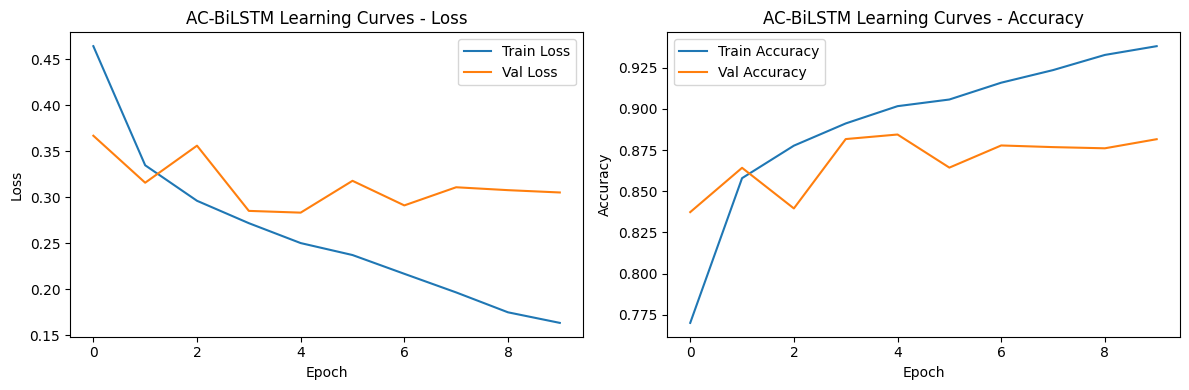

In [23]:
#### YOUR CODE ####
# Plot learning curves
# Plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses_ac, label='Train Loss')
ax1.plot(val_losses_ac, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('AC-BiLSTM Learning Curves - Loss')
ax1.legend()

ax2.plot(train_accs_ac, label='Train Accuracy')
ax2.plot(val_accs_ac, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('AC-BiLSTM Learning Curves - Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [24]:
#### YOUR CODE ####
# Show diagnostics
print("Confusion Matrix:")
print(cm_ac)
print("\nClassification Report:")
print(report_ac)

Confusion Matrix:
[[11193  1307]
 [ 1653 10847]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.90      0.88     12500
    Positive       0.89      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



# Conclusion



## Question 6
You can refer to the paper for this question.
1) What is the purpose of the convolutional layer in this architecture?
2) You were told to concatenate the forward and backward hidden states output from Bi-LSTM, why ?
3) Why does adding soft attention improve performance of the model?
4) Compare the performance results to the results you obtained in HW5. Which model would you choose? What about model complexity in each case (with or without fine-tuning?, you can give an estimate of the nearest order of magnitude of the model's number of trainable parameters)?
5) Can you explain in short sentences if you were to swap the convolutional layer and embedding to a pretrained transformer head like BERT to combine it with the bidirectional LSTM, how would you do?

**Your answer**:

1.The role of the convolutional layer: It extracts local n-gram features (in this question, n=3), captures phrase-level semantics in the text (such as "not good", "very excellent"), and provides more effective local feature inputs for the subsequent LSTM, compensating for the inefficiency of LSTM in capturing short-distance dependencies.

2.The reason for concatenating the hidden states of bidirectional LSTM: Unidirectional LSTM can only capture the context from "history → current", while bidirectional LSTM captures both "history → current" (forward) and "future → current" (backward) contexts. Concatenating the hidden states of both can integrate complete bidirectional context information, allowing the model to focus on both the preceding and following contexts of the target word in the text.

3.The reason why the attention mechanism improves performance: LSTM only relies on the hidden state of the last time step, which may lose key information in long sequences; the attention mechanism dynamically focuses on the most important keywords for sentiment judgment (such as sentiment words, negation words) by weighted summation of all time step hidden states, suppressing filler words and redundant information, making the context representation more targeted.

4.Comparison with the HW5 model:
◦ Performance: AC-BiLSTM (convolution + bidirectional LSTM + attention) > C-BiLSTM (convolution + bidirectional LSTM) > Word2vec+CNN > BoW+Logistic. The attention mechanism and bidirectional context make AC-BiLSTM more accurate in long text sentiment analysis.
◦ Model complexity:
◦ BoW+Logistic: No training parameters (only logistic regression weights).
◦ Word2vec+CNN: When Word2vec is frozen, only CNN and classification head are trained.
◦ C-BiLSTM: When Word2vec is frozen, CNN + bidirectional LSTM + classification head.
◦ AC-BiLSTM: On the basis of C-BiLSTM, it adds an attention mechanism, slightly higher complexity but significant improvement.

5.Remove the original Word2vec embedding layer and convolutional layer, and replace them with the pre-trained BERT embedding layer (including word embeddings, segment embeddings, and position embeddings).
Freeze or fine-tune the BERT layer: If frozen, only the Bi-LSTM and classification head are trained; if fine-tuned, BERT and subsequent layers are trained together.
Use the output of the [CLS] token of BERT or the average pooling output of all tokens as the input of Bi-LSTM, and retain the bidirectional LSTM and attention mechanism in the subsequent layers.

# 4. *Optional: BERT+Bi-LSTM*

Bonus question: can you rerun the pipeline using a BERT + Bi-LSTM architecture? Note: you should not be using the Word2vec embedding but you can use a pretrained BERT. Justify your choices concisely.

Comment on why BERT is an appropriate transformer-based model for text classification, how does it differ conceptually to LLM architectures?

In [46]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding

# ========== Speed knobs (GPU) ==========
torch.backends.cuda.matmul.allow_tf32 = True              # allow TF32 on Ampere+ for speed (safe for training)
torch.set_float32_matmul_precision("high")                # PyTorch 2.x speed hint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Use AutoTokenizer so you can switch model easily (bert / distilbert, etc.)
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

MAX_LEN = 256  # <<< big speed win vs 512 for IMDB
BATCH_SIZE = 16

class BertTextDataset(Dataset):
    """
    Returns raw text + label. Tokenization and padding happen in collator for speed.
    """
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels  # 0/1

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "text": self.texts[idx],
            "label": float(self.labels[idx])  # BCEWithLogitsLoss expects float
        }

def collate_fn(batch):
    """
    Dynamic padding collator:
    1) tokenize batch texts together (vectorized, fast)
    2) pad only to batch max length
    """
    texts = [x["text"] for x in batch]
    labels = torch.tensor([x["label"] for x in batch], dtype=torch.float32)

    enc = tokenizer(
        texts,
        truncation=True,
        max_length=MAX_LEN,
        padding=True,                 # pad to longest in THIS batch
        return_tensors="pt"
    )

    enc["labels"] = labels
    return enc

train_dataset = BertTextDataset(train_texts, train_labels)
test_dataset  = BertTextDataset(test_texts,  test_labels)

# DataLoader speedups:
# - num_workers: parallel CPU tokenization/batching overhead (collate still runs in main, but workers help IO)
# - pin_memory: faster H2D transfer
# - persistent_workers: avoid worker restart each epoch
num_workers = min(4, os.cpu_count() or 1)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=(num_workers > 0),
    collate_fn=collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=(num_workers > 0),
    collate_fn=collate_fn
)


Using device: cuda


In [47]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, H, mask):
        """
        H:    (B, T, D)
        mask: (B, T)  1=valid token, 0=padding
        """
        u = torch.tanh(self.W(H))            # (B,T,D)
        scores = self.v(u).squeeze(-1)       # (B,T)

        # fp16-safe masking: use dtype minimum instead of -1e9
        neg_inf = torch.finfo(scores.dtype).min
        scores = scores.masked_fill(mask == 0, neg_inf)

        alpha = torch.softmax(scores, dim=1) # (B,T)
        ctx = torch.sum(H * alpha.unsqueeze(-1), dim=1)  # (B,D)
        return ctx

class BERT_BiLSTM(nn.Module):
    """
    BERT encoder -> BiLSTM -> Attention -> Binary classification
    """
    def __init__(self, model_name=MODEL_NAME, lstm_hidden=128, lstm_layers=1, dropout=0.3, train_last_n_bert_layers=2):
        super().__init__()

        self.bert = AutoModel.from_pretrained(model_name)

        # ---------- Proper layer freezing (IMPORTANT) ----------
        # Freeze all first
        for p in self.bert.parameters():
            p.requires_grad = False

        # Unfreeze last N encoder layers if possible (BERT has encoder.layer; DistilBERT has transformer.layer)
        # This avoids your old "parameters()[0:-4]" mistake.
        if hasattr(self.bert, "encoder") and hasattr(self.bert.encoder, "layer"):
            layers = self.bert.encoder.layer
            for layer in layers[-train_last_n_bert_layers:]:
                for p in layer.parameters():
                    p.requires_grad = True
        elif hasattr(self.bert, "transformer") and hasattr(self.bert.transformer, "layer"):
            layers = self.bert.transformer.layer
            for layer in layers[-train_last_n_bert_layers:]:
                for p in layer.parameters():
                    p.requires_grad = True
        else:
            # fallback: keep fully frozen
            pass

        bert_hidden = self.bert.config.hidden_size

        self.lstm = nn.LSTM(
            input_size=bert_hidden,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=(dropout if lstm_layers > 1 else 0.0)
        )

        self.attn = Attention(hidden_dim=2 * lstm_hidden)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * lstm_hidden, 1)

    def forward(self, input_ids, attention_mask):
        # If most of BERT is frozen, no_grad speeds forward a lot
        if not any(p.requires_grad for p in self.bert.parameters()):
            with torch.no_grad():
                out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        else:
            out = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        H = out.last_hidden_state                 # (B,T,bert_hidden)
        lstm_out, _ = self.lstm(H)                # (B,T,2*lstm_hidden)

        ctx = self.attn(lstm_out, attention_mask) # (B,2*lstm_hidden)
        logits = self.fc(self.drop(ctx))          # (B,1)
        return logits


In [48]:
# =========================
# Cell C (兼容版：消除 autocast deprecation warning)
# =========================

import torch
from sklearn.metrics import confusion_matrix, classification_report

# 兼容 autocast：优先用 torch.amp.autocast；否则回退 torch.cuda.amp.autocast
try:
    from torch.amp import autocast as autocast_ctx   # 新版
except Exception:
    from torch.cuda.amp import autocast as autocast_ctx  # 旧版

def train_one_epoch(model, dataloader, criterion, optimizer, scaler, device):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True).unsqueeze(1)

        optimizer.zero_grad(set_to_none=True)

        # ✅ 用兼容 autocast，上层用 enabled 控制是否启用 AMP
        # 注意：新版 autocast 推荐写 autocast_ctx("cuda", enabled=...)
        # 但旧版签名是 autocast_ctx(enabled=...)
        if device.type == "cuda":
            try:
                ctx = autocast_ctx("cuda", enabled=True)
            except TypeError:
                ctx = autocast_ctx(enabled=True)
        else:
            # CPU 不开 AMP
            try:
                ctx = autocast_ctx("cpu", enabled=False)
            except TypeError:
                ctx = autocast_ctx(enabled=False)

        with ctx:
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * input_ids.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        total_correct += (preds == labels).sum().item()
        total_samples += input_ids.size(0)

    return total_loss / total_samples, total_correct / total_samples


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    all_preds, all_labels = [], []

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True).unsqueeze(1)

        if device.type == "cuda":
            try:
                ctx = autocast_ctx("cuda", enabled=True)
            except TypeError:
                ctx = autocast_ctx(enabled=True)
        else:
            try:
                ctx = autocast_ctx("cpu", enabled=False)
            except TypeError:
                ctx = autocast_ctx(enabled=False)

        with ctx:
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

        total_loss += loss.item() * input_ids.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()

        total_correct += (preds == labels).sum().item()
        total_samples += input_ids.size(0)

        all_preds.extend(preds.squeeze(1).cpu().numpy().tolist())
        all_labels.extend(labels.squeeze(1).cpu().numpy().tolist())

    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=["Negative", "Positive"], output_dict=True)
    return total_loss / total_samples, total_correct / total_samples, cm, report



In [49]:
# =========================
# Cell D (兼容版：可继续运行)
# 依赖：Cell A/B/C 已经成功运行
# 作用：实例化模型、定义 loss/optimizer/scaler、训练、保存 best、加载 best、最终评估
# =========================

import torch
import torch.nn as nn

# ---------- 1) Instantiate model ----------
bert_bilstm_model = BERT_BiLSTM(
    model_name=MODEL_NAME,
    lstm_hidden=128,
    lstm_layers=1,
    dropout=0.3,
    train_last_n_bert_layers=2   # 更快: 0；更准但更慢: 4/6
).to(device)

# ---------- 2) Loss function ----------
criterion = nn.BCEWithLogitsLoss()

# ---------- 3) Optimizer ----------
optimizer = torch.optim.AdamW(
    (p for p in bert_bilstm_model.parameters() if p.requires_grad),
    lr=2e-4,
    weight_decay=1e-2
)

# ---------- 4) AMP scaler (兼容不同版本的 PyTorch) ----------
# 解释：
# - 你环境里 GradScaler 不接受 device_type 这个参数
# - 最兼容写法：优先用 torch.amp.GradScaler()，若不存在就退回 torch.cuda.amp.GradScaler()
try:
    from torch.amp import GradScaler  # 新版位置
    scaler = GradScaler(enabled=(device.type == "cuda"))
except Exception:
    from torch.cuda.amp import GradScaler  # 旧版位置
    scaler = GradScaler(enabled=(device.type == "cuda"))

# ---------- 5) Training loop ----------
EPOCHS = 5
best_val_loss = float("inf")
best_model_path = "best_bert_bilstm.pt"

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_one_epoch(
        model=bert_bilstm_model,
        dataloader=train_dataloader,
        criterion=criterion,
        optimizer=optimizer,
        scaler=scaler,
        device=device
    )

    va_loss, va_acc, va_cm, va_report = evaluate(
        model=bert_bilstm_model,
        dataloader=test_dataloader,
        criterion=criterion,
        device=device
    )

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(va_loss)
    val_accs.append(va_acc)

    print(
        f"[Epoch {epoch+1}/{EPOCHS}] "
        f"Train Loss={tr_loss:.4f} Acc={tr_acc:.4f} | "
        f"Val Loss={va_loss:.4f} Acc={va_acc:.4f}"
    )

    if va_loss < best_val_loss:
        best_val_loss = va_loss
        torch.save(bert_bilstm_model.state_dict(), best_model_path)
        print(f"  Saved best model (val_loss={best_val_loss:.4f})")

# ---------- 6) Load best model ----------
best_model = BERT_BiLSTM(
    model_name=MODEL_NAME,
    lstm_hidden=128,
    lstm_layers=1,
    dropout=0.3,
    train_last_n_bert_layers=2
).to(device)

best_model.load_state_dict(torch.load(best_model_path, map_location=device))

# ---------- 7) Final evaluation ----------
final_loss, final_acc, final_cm, final_report = evaluate(
    model=best_model,
    dataloader=test_dataloader,
    criterion=criterion,
    device=device
)

print("\n=== Final Model Performance ===")
print(f"Test Loss: {final_loss:.4f}")
print(f"Test Acc : {final_acc:.4f}")
print("Confusion Matrix:\n", final_cm)
print(f"Positive F1: {final_report['Positive']['f1-score']:.4f}")
print(f"Negative F1: {final_report['Negative']['f1-score']:.4f}")
print(f"Weighted F1: {final_report['weighted avg']['f1-score']:.4f}")


[Epoch 1/5] Train Loss=0.2897 Acc=0.8797 | Val Loss=0.2357 Acc=0.9047
  Saved best model (val_loss=0.2357)
[Epoch 2/5] Train Loss=0.2373 Acc=0.9042 | Val Loss=0.2273 Acc=0.9110
  Saved best model (val_loss=0.2273)
[Epoch 3/5] Train Loss=0.2108 Acc=0.9169 | Val Loss=0.2326 Acc=0.9070
[Epoch 4/5] Train Loss=0.1893 Acc=0.9281 | Val Loss=0.2343 Acc=0.9076
[Epoch 5/5] Train Loss=0.1703 Acc=0.9356 | Val Loss=0.2271 Acc=0.9104
  Saved best model (val_loss=0.2271)

=== Final Model Performance ===
Test Loss: 0.2271
Test Acc : 0.9104
Confusion Matrix:
 [[11118  1382]
 [  858 11642]]
Positive F1: 0.9122
Negative F1: 0.9085
Weighted F1: 0.9104


In [26]:


# import torch
# import torch.nn as nn
# import numpy as np
# import matplotlib.pyplot as plt
# from transformers import BertTokenizer, BertModel
# from torch.utils.data import Dataset, DataLoader
# from sklearn.metrics import confusion_matrix, classification_report
# from collections import Counter
# import re, html, unicodedata
# import os, tarfile, urllib.request
# from pathlib import Path
# from pprint import pprint

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")


# # url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
# # DATA_DIR = "aclImdb"
# # if not os.path.exists(DATA_DIR):
# #     print("Downloading IMDB dataset...")
# #     urllib.request.urlretrieve(url, "aclImdb_v1.tar.gz")
# #     print("Extracting...")
# #     with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
# #         tar.extractall()
# #     print("Done!")
# # else:
# #     print("IMDB dataset already exists.")


# # def load_imdb_split(split_dir):
# #     texts, labels = [], []
# #     for label_type in ["pos", "neg"]:
# #         dir_path = Path(split_dir) / label_type
# #         for file_path in dir_path.iterdir():
# #             with open(file_path, encoding="utf-8") as f:
# #                 texts.append(f.read())  # 修复原代码的语法错误（漏写texts.）
# #             labels.append(1 if label_type == "pos" else 0)
# #     return texts, labels

# # train_texts, train_labels = load_imdb_split(DATA_DIR + "/train")
# # test_texts, test_labels = load_imdb_split(DATA_DIR + "/test")
# # print(f"Loaded {len(train_texts)} train and {len(test_texts)} test reviews.")

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# class BertTextDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_len=512):
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         label = self.labels[idx]

#         encoding = self.tokenizer(
#             text,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             padding='max_length',
#             truncation=True,
#             return_attention_mask=True,
#             return_tensors='pt'
#         )

#         return {
#             'input_ids': encoding['input_ids'].flatten(),  # (512,)
#             'attention_mask': encoding['attention_mask'].flatten(),  # (512,)
#             'label': torch.tensor(label, dtype=torch.float32)
#         }

# batch_size = 16
# train_dataset = BertTextDataset(train_texts, train_labels, tokenizer, max_len=512)
# test_dataset = BertTextDataset(test_texts, test_labels, tokenizer, max_len=512)

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# class Attention(nn.Module):
#     def __init__(self, hidden_dim):
#         super().__init__()
#         self.W = nn.Linear(hidden_dim, hidden_dim)
#         self.v = nn.Linear(hidden_dim, 1, bias=False)

#     def forward(self, h):
#         batch_size, max_len, hidden_dim = h.shape

#         u_h = torch.tanh(self.W(h))  # (batch_size, 512, hidden_dim)

#         attn_scores = self.v(u_h)  # (batch_size, 512, 1)

#         return None, None

# class BERT_BiLSTM(nn.Module):
#     def __init__(self, bert_model_name='bert-base-uncased', hidden_dim=150, dropout=0.7):
#         super().__init__()
#         self.bert = BertModel.from_pretrained(bert_model_name)
#         for param in list(self.bert.parameters())[:-4]:
#             param.requires_grad = False

#         self.lstm = nn.LSTM(
#             input_size=768,
#             hidden_size=hidden_dim,
#             bidirectional=True,
#             batch_first=True,
#             num_layers=1,
#             dropout=dropout if 1 > 1 else 0
#         )

#         self.attention_f = Attention(hidden_dim)
#         self.attention_b = Attention(hidden_dim)

#         self.dropout = nn.Dropout(dropout)
#         self.clf = nn.Linear(2 * hidden_dim, 1)

#     def forward(self, input_ids, attention_mask):

#         bert_out = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             return_dict=True
#         )

#         lstm_input = bert_out.last_hidden_state

#         lstm_out, _ = self.lstm(lstm_input)  # (batch_size,512, 300)
#         h_f = lstm_out[:, :, :hidden_dim]
#         h_b = lstm_out[:, :, hidden_dim:]

#         u_f = torch.tanh(self.attention_f.W(h_f))  # (batch_size,512,150)
#         attn_scores_f = self.attention_f.v(u_f)    # (batch_size,512,1)
#         attn_scores_f = attn_scores_f.masked_fill(attention_mask.unsqueeze(-1) == 0, -1e9)
#         attn_weights_f = torch.softmax(attn_scores_f, dim=1)  # (batch_size,512,1)
#         c_f = torch.sum(attn_weights_f * h_f, dim=1)

#         u_b = torch.tanh(self.attention_b.W(h_b))
#         attn_scores_b = self.attention_b.v(u_b)
#         attn_scores_b = attn_scores_b.masked_fill(attention_mask.unsqueeze(-1) == 0, -1e9)
#         attn_weights_b = torch.softmax(attn_scores_b, dim=1)
#         c_b = torch.sum(attn_weights_b * h_b, dim=1)

#         context = torch.cat([c_f, c_b], dim=1)  # (batch_size, 300)
#         dropout_out = self.dropout(context)
#         logits = self.clf(dropout_out)  # (batch_size, 1)

#         return logits

# def train_bert(model, dataloader, criterion, optimizer, device):
#     model.train()
#     total_loss = 0.0
#     total_correct = 0
#     total_samples = 0

#     for batch in dataloader:
#         input_ids = batch['input_ids'].to(device)  # (batch_size,512)
#         attention_mask = batch['attention_mask'].to(device)  # (batch_size,512)
#         labels = batch['label'].to(device).unsqueeze(1)  # (batch_size,1)

#         optimizer.zero_grad()
#         logits = model(input_ids, attention_mask)  # (batch_size,1)
#         loss = criterion(logits, labels)

#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item() * input_ids.size(0)
#         preds = (torch.sigmoid(logits) > 0.5).float()
#         total_correct += (preds == labels).sum().item()
#         total_samples += input_ids.size(0)

#     avg_loss = total_loss / total_samples
#     avg_acc = total_correct / total_samples
#     return avg_loss, avg_acc

# def evaluate_bert(model, dataloader, criterion, device):
#     model.eval()
#     total_loss = 0.0
#     total_correct = 0
#     total_samples = 0
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for batch in dataloader:
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['label'].to(device).unsqueeze(1)

#             logits = model(input_ids, attention_mask)
#             loss = criterion(logits, labels)


#             total_loss += loss.item() * input_ids.size(0)
#             preds = (torch.sigmoid(logits) > 0.5).float()
#             total_correct += (preds == labels).sum().item()
#             total_samples += input_ids.size(0)


#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     avg_loss = total_loss / total_samples
#     avg_acc = total_correct / total_samples
#     cm = confusion_matrix(all_labels, all_preds)
#     report = classification_report(
#         all_labels, all_preds,
#         target_names=["Negative", "Positive"],
#         output_dict=True
#     )
#     return avg_loss, avg_acc, cm, report

# bert_bilstm_model = BERT_BiLSTM(
#     bert_model_name='bert-base-uncased',
#     hidden_dim=150,
#     dropout=0.7
# ).to(device)

# criterion = nn.BCEWithLogitsLoss()

# optimizer = torch.optim.AdamW(
#     bert_bilstm_model.parameters(),
#     lr=2e-5,
#     weight_decay=1e-4
# )

# EPOCHS = 5
# best_val_loss = float('inf')
# best_model_path = "best_bert_bilstm.pth"

# train_losses = []
# train_accs = []
# val_losses = []
# val_accs = []

# for epoch in range(EPOCHS):
#     print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")


#     train_loss, train_acc = train_bert(bert_bilstm_model, train_dataloader, criterion, optimizer, device)
#     train_losses.append(train_loss)
#     train_accs.append(train_acc)
#     print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

#     # 验证
#     val_loss, val_acc, cm, report = evaluate_bert(bert_bilstm_model, test_dataloader, criterion, device)
#     val_losses.append(val_loss)
#     val_accs.append(val_acc)
#     print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

#     # 保存最佳模型（基于验证损失）
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(bert_bilstm_model.state_dict(), best_model_path)
#         print(f"Best model saved (Val Loss: {best_val_loss:.4f})")

# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(train_losses, label="Train Loss", marker='o')
# plt.plot(val_losses, label="Val Loss", marker='s')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("BERT+BiLSTM Loss Curve")
# plt.legend()
# plt.grid(alpha=0.3)

# plt.subplot(1, 2, 2)
# plt.plot(train_accs, label="Train Acc", marker='o')
# plt.plot(val_accs, label="Val Acc", marker='s')
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("BERT+BiLSTM Accuracy Curve")
# plt.legend()
# plt.grid(alpha=0.3)

# plt.tight_layout()
# plt.show()


# best_model = BERT_BiLSTM(hidden_dim=150, dropout=0.7).to(device)
# best_model.load_state_dict(torch.load(best_model_path))

# final_loss, final_acc, final_cm, final_report = evaluate_bert(best_model, test_dataloader, criterion, device)

# print("\n=== Final Model Performance ===")
# print(f"Test Accuracy: {final_acc:.4f}")
# print(f"Test Loss: {final_loss:.4f}")
# print("\nConfusion Matrix:")
# print(final_cm)
# print("\nClassification Report:")
# print(f"Positive F1-Score: {final_report['Positive']['f1-score']:.4f}")
# print(f"Negative F1-Score: {final_report['Negative']['f1-score']:.4f}")
# print(f"Weighted F1-Score: {final_report['weighted avg']['f1-score']:.4f}")

Using device: cuda

=== Epoch 1/5 ===
Train Loss: 0.4694 | Train Acc: 0.7841


KeyboardInterrupt: 